# Model Monitoring with Pre/Post Processing

For an intro on Model Monitoring, please see the [official tutorial](https://docs.mlrun.org/en/latest/tutorial/05-model-monitoring.html). This example shows how to use model monitoring with custom pre-processing, post-processing, and KPIs

In [1]:
# !pip install scikit-learn==1.0.1

### Setup MLRun Project

In [2]:
import mlrun
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
project = mlrun.get_or_create_project("model-monitoring-custom", "./")

> 2023-04-03 22:13:04,902 [info] loaded project model-monitoring-custom from MLRun DB


### Log Model with Dataset

In [5]:
MODEL_NAME = "iris"
MODEL_PATH = 'https://s3.wasabisys.com/iguazio/models/model-monitoring/model-3.7.pkl'
DATA_PATH = 'https://s3.wasabisys.com/iguazio/data/model-monitoring/iris_dataset.csv'

In [6]:
model_artifact = project.log_model(
    key=MODEL_NAME,
    model_file=MODEL_PATH,
    framework="sklearn",
    training_set=pd.read_csv(DATA_PATH),
    label_column="label"
)

In [7]:
model_uri = model_artifact.uri
model_uri

'store://models/model-monitoring-custom/iris#0:latest'

### Define Model Class, Router, and Transformations

In [8]:
%%writefile serve.py
from typing import List

import numpy as np
import storey
from cloudpickle import load
import random

import mlrun
from mlrun.serving.routers import ParallelRun

class ClassifierModel(mlrun.serving.V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model(".pkl")
        self.model = load(open(model_file, "rb"))
        
    def validate(self, request, operation):
        """Removed default validation"""
        return request
        
    def preprocess(self, request: dict, operation) -> dict:
        """preprocess the event body before validate and action"""
        request["inputs"] = [list(request.values())]
        return request

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
            
        #### Custom KPI
        self.set_metric("my_kpi", random.uniform(1, 10))
        ####
        
        return result.tolist()

def format_prediction(event):
    CLASS_MAPPINGS = {0: "setosa", 1 : "versicolor", 2: "virginica"}

    return {
        "model_name" : event["model_name"],
        "prediction" : CLASS_MAPPINGS[event["outputs"][0]]
    }

Overwriting serve.py


### Define Graph

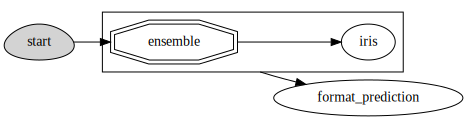

In [12]:
fn = project.set_function(
    name="model-server", func="serve.py", 
    kind="serving", image="mlrun/mlrun"
)
graph = fn.set_topology("flow", engine="async")

router = graph.add_step("*mlrun.serving.ModelRouter", name="ensemble")
router.add_route("iris", class_name="ClassifierModel", model_path=model_uri)

graph.add_step(name="format_prediction", handler="format_prediction", after="$prev").respond()

graph.plot(rankdir="LR")

### Test Locally

In [13]:
mock_server = fn.to_mock_server()

> 2023-04-03 22:13:42,462 [info] model iris was loaded
> 2023-04-03 22:13:42,463 [info] Loaded ['iris']


In [14]:
body = {
    "sepal_length_cm": 5.1,
    "sepal_width_cm": 3.5,
    "petal_length_cm": 1.4,
    "petal_width_cm": 0.2,
}

In [15]:
mock_server.test("", body=body)

{'model_name': 'iris', 'prediction': 'setosa'}

### Enable Monitoring + Deploy on K8s

In [16]:
fn.set_tracking()

In [17]:
fn.deploy()

> 2023-04-03 22:13:46,386 [info] Starting remote function deploy
2023-04-03 22:13:49  (info) Deploying function
2023-04-03 22:13:49  (info) Building
2023-04-03 22:13:49  (info) Staging files and preparing base images
2023-04-03 22:13:49  (info) Building processor image
2023-04-03 22:14:35  (info) Build complete
2023-04-03 22:14:43  (info) Function deploy complete
> 2023-04-03 22:14:43,517 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-model-monitoring-custom-model-server.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['model-monitoring-custom-model-server-model-monitoring-custom.default-tenant.app.us-sales-350.iguazio-cd1.com/']}


'http://model-monitoring-custom-model-server-model-monitoring-custom.default-tenant.app.us-sales-350.iguazio-cd1.com/'

In [18]:
body = {
    "sepal_length_cm": 5.1,
    "sepal_width_cm": 3.5,
    "petal_length_cm": 1.4,
    "petal_width_cm": 0.2,
}

In [19]:
fn.invoke("", body=body)

> 2023-04-03 22:14:49,762 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-model-monitoring-custom-model-server.default-tenant.svc.cluster.local:8080/'}


{'model_name': 'iris', 'prediction': 'setosa'}

### Simulate production traffic

*By default, the drift calculation starts via the scheduled hourly batch job after receiving 10,000 incoming requests.*

In [21]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Get training set as list
iris_data = pd.read_csv(DATA_PATH).drop("label", axis=1).to_dict(orient="records")

# Simulate traffic using random elements from training set
for i in tqdm(range(12_000)):
    data_point = choice(iris_data)
    fn.invoke(f'v2/models/{MODEL_NAME}/infer', data_point)
    
# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)

  0%|          | 0/12000 [00:00<?, ?it/s]